<a href="https://colab.research.google.com/github/cocobridge696/ML/blob/main/Clear_Sky_Solar_Irradiance_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from google.colab import files
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

files.upload()

Saving DATA.csv to DATA.csv


{'DATA.csv': b'-BEGIN HEADER-\r\nNASA/POWER CERES/MERRA2 Native Resolution Hourly Data \r\nDates (month/day/year): 01/01/2019 through 03/31/2021 \r\nLocation: Latitude  52.2498   Longitude -1.2443 \r\nElevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 107.45 meters\r\nValue for missing model data cannot be computed or out of model availability range: -999 \r\nParameter(s): \r\nQV2M                  MERRA-2 Specific Humidity at 2 Meters (g/kg) \r\nRH2M                  MERRA-2 Relative Humidity at 2 Meters (%) \r\nALLSKY_SFC_SW_DWN     CERES SYN1deg All Sky Surface Shortwave Downward Irradiance (Wh/m^2) \r\nCLRSKY_SFC_SW_DWN     CERES SYN1deg Clear Sky Surface Shortwave Downward Irradiance (Wh/m^2) \r\n-END HEADER-\r\nYEAR,MO,DY,HR,QV2M,RH2M,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN\n2019,1,1,0,5.43,95.56,0.0,0.0\n2019,1,1,1,5.43,95.75,0.0,0.0\n2019,1,1,2,5.43,95.88,0.0,0.0\n2019,1,1,3,5.49,94.31,0.0,0.0\n2019,1,1,4,5.55,93.44,0.0,0.0\n2019,1,1,5,5.55,93.5,0.0,0.0\n2019,1

In [ ]:
data=pd.read_csv('DATA.csv',skiprows=12)
data.head()

,YEAR,MO,DY,HR,QV2M,RH2M,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN
0,2019,1,1,0,5.43,95.56,0.0,0.0
1,2019,1,1,1,5.43,95.75,0.0,0.0
2,2019,1,1,2,5.43,95.88,0.0,0.0
3,2019,1,1,3,5.49,94.31,0.0,0.0
4,2019,1,1,4,5.55,93.44,0.0,0.0


Text(0, 0.5, 'Clear Sky Irradiance (Whm^-2)')

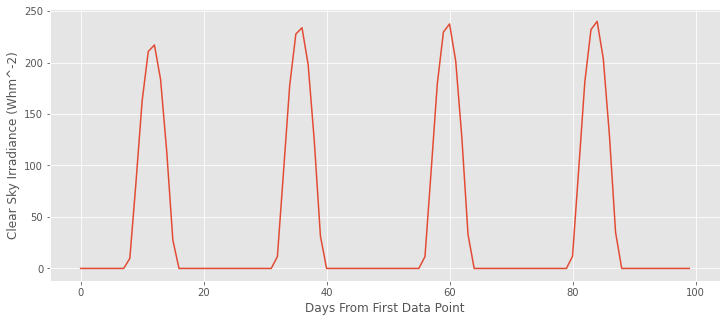

In [ ]:
data['CLRSKY_SFC_SW_DWN'][0:100].plot(figsize=(12,5))
plt.xlabel('Days From First Data Point')
plt.ylabel('Clear Sky Irradiance (Whm^-2)')



# LSTM model

In [ ]:
#normalize data
data=data[data.keys()[4:]]
norm_data=(data-data.mean())/data.std()
print(norm_data)


           QV2M      RH2M  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN
0     -0.536291  0.633915          -0.648549          -0.705622
1     -0.536291  0.646528          -0.648549          -0.705622
2     -0.536291  0.655158          -0.648549          -0.705622
3     -0.507276  0.550938          -0.648549          -0.705622
4     -0.478260  0.493186          -0.648549          -0.705622
...         ...       ...                ...                ...
19699  0.764579 -0.274186          -0.648549          -0.705622
19700  0.672696  0.073654          -0.648549          -0.705622
19701  0.643681  0.318602          -0.648549          -0.705622
19702  0.614665  0.360423          -0.648549          -0.705622
19703  0.556633  0.501152          -0.648549          -0.705622

[19704 rows x 4 columns]


Text(0, 0.5, 'Clear Sky Irradiance (Whm^-2)')

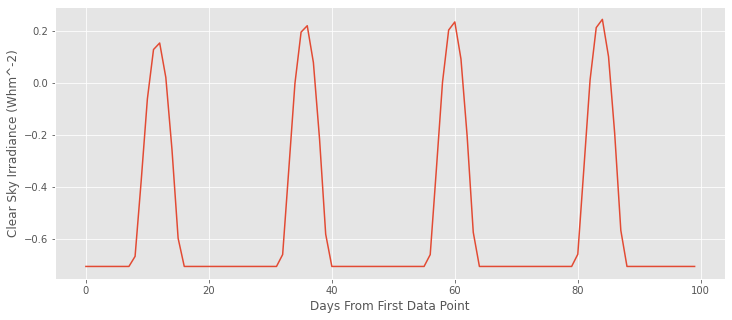

In [ ]:
norm_data['CLRSKY_SFC_SW_DWN'][0:100].plot(figsize=(12,5))
plt.xlabel('Days From First Data Point')
plt.ylabel('Clear Sky Irradiance (Whm^-2)')

In [ ]:
#put in form of [all data points before for multiple chosen variables for as long back as chosen history size]

def format_data(dataset,label,start,end,history_size,target_size,single_step,step):
  data=[]
  labels=[]
  start=start+history_size
  if end is None:
    end=len(dataset)-target_size
  for i in range(start,end):
    indicies=[range(i-history_size,i,step)]
    data.append(dataset[indicies])
    if single_step:
      labels.append(label[i+target_size])
    else:
      labels.append(label[i:i+target_size])
  return np.array(data),np.array(labels)

In [ ]:
#start off predicting a single day ahead using stationary data
history_size=5

data,labels=format_data(norm_data.values,norm_data.values[:,3],0,None,history_size,0,True,1)

trainsplit=0.8

trainsplit=int(len(data)*trainsplit)
tr_labels=labels[0:trainsplit]
train=data[0:trainsplit]

test=data[trainsplit:]
te_labels=labels[trainsplit:]

print(train.shape,tr_labels.shape,test.shape,te_labels.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


(15759, 5, 4) (15759,) (3940, 5, 4) (3940,)


In [ ]:
#lstm model

import tensorflow as tf

input_shape=train.shape[-2:] #=historysize,1

lstm_model=tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(64,input_shape=input_shape))
lstm_model.add(tf.keras.layers.Dense(100,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(36,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1))
lstm_model.compile(optimizer='adam',loss='mse')

In [ ]:
#DNN model
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Dense(100,activation='relu',input_shape=input_shape),
                                  tf.keras.layers.Dense(36,activation='relu'),
                                  tf.keras.layers.Dense(16,activation='relu'),
                                  tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam',loss='mse')

In [ ]:
epochs=10



result=lstm_model.fit(x=train,y=tr_labels,epochs=epochs,validation_data=(test,te_labels))

Epoch 1/10
493/493 [==============================] - 10s 6ms/step - loss: 0.0641 - val_loss: 0.0092
Epoch 2/10
493/493 [==============================] - 2s 5ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 3/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 4/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 6/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 7/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 8/10
493/493 [==============================] - 3s 5ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/10
493/493 [==============================] - 2s 5ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 10/10
493/493 [==============================] - 2s 5ms/step - loss: 0.0025 - val_loss: 0.002

In [ ]:
result.history['val_loss'][-1]

0.002758956514298916

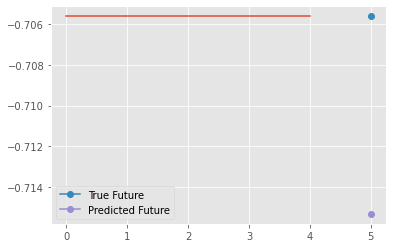

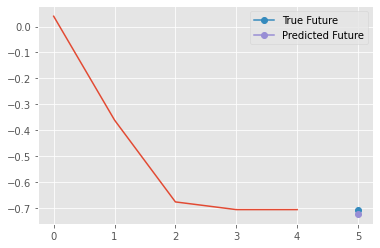

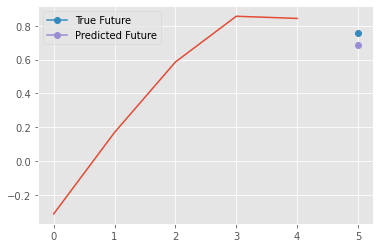

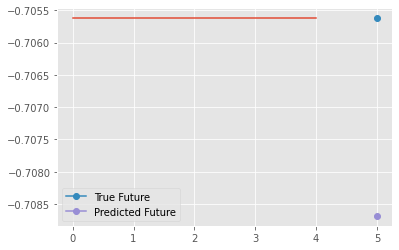

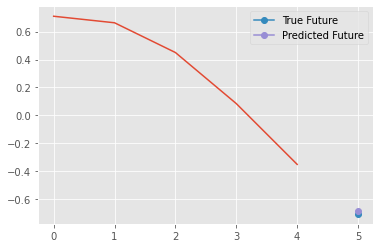

In [ ]:
from random import randint
for y in range(5):
  x=randint(0,len(test)-1)
  plt.figure()
  plt.plot(test[x,:,3])
  plt.plot(history_size,te_labels[x],marker='o',label='True Future')
  plt.plot(history_size,lstm_model.predict(test[x].reshape(1,history_size,-1)),marker='o',label='Predicted Future')
  plt.legend()

The lstm model achieved a MSE of 0.0028 while the basline MSE was 0.0437


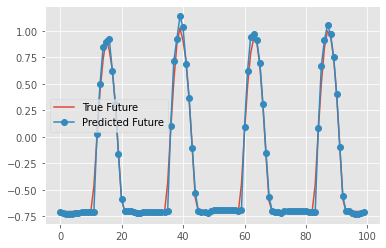

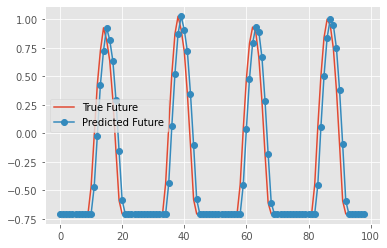

In [ ]:
x=100
plt.plot(range(x),te_labels[0:x],label='True Future')
plt.plot(lstm_model.predict(test[:x]),marker='o',label='Predicted Future')
plt.legend()
plt.ylabel('')
plt.xlabel('')

lstm_mse=tf.keras.losses.MSE(te_labels.reshape(-1),lstm_model.predict(test).reshape(-1))

#compare with using just previous datapoint to predict future which can be considered a basline
plt.figure()
x=100
plt.plot(range(x-1),te_labels[1:x],label='True Future')
plt.plot(range(x-1),te_labels[:x-1],marker='o',label='Predicted Future')
plt.legend()
basline_mse=tf.keras.losses.MSE(te_labels[1:].reshape(-1),te_labels[:-1].reshape(-1))
numner=0.000505
print('The lstm model achieved a MSE of {:0.4f} while the basline MSE was {:0.4f}'.format(lstm_mse,basline_mse))

## Finding optimium history size

In [ ]:
def opt_hist(norm_data,history_range,trainsplit,epochs):
  count=0
  final_loss=np.zeros([len(history_range),2])
  final_loss[:,0]=history_range
  for x in history_range:
    data,labels=format_data(norm_data,norm_data[:,3],0,None,x,0,True,1)
    train_split=int(len(data)*trainsplit)
    tr_labels=labels[0:train_split]
    train=data[0:train_split]
    test=data[train_split:]
    te_labels=labels[train_split:]
    #lstm model
    lstm_model=None
    import tensorflow as tf
    input_shape=train.shape[-2:] 
    lstm_model=tf.keras.models.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(64,input_shape=input_shape))
    lstm_model.add(tf.keras.layers.Dense(100,activation='relu'))
    lstm_model.add(tf.keras.layers.Dense(36,activation='relu'))
    lstm_model.add(tf.keras.layers.Dense(1))
    lstm_model.compile(optimizer='adam',loss='mse')
    results=lstm_model.fit(x=train,y=tr_labels,epochs=epochs,validation_data=(test,te_labels),verbose=0)
    print(count)
    final_loss[count,1]=min(results.history['val_loss'])
    count+=1
  return final_loss


In [ ]:
history_range=range(3,30,2)
epochs=10
trainsplit=0.8
params=opt_hist(norm_data.values,history_range,trainsplit,epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
min_loss=min(params[:,1])
opt_history=params[:,0][np.where(params[:,1]==min_loss)][0]
print('The lowest loss achieved was a MSE of {:0.4f} with a history size of {:0.4f}'.format(min_loss,opt_history))

The lowest loss achieved was a MSE of 0.0006 with a history size of 27.0000


In [ ]:
print(params)

[[3.00000000e+00 2.41489755e-03]
 [5.00000000e+00 2.13349168e-03]
 [7.00000000e+00 2.51420494e-03]
 [9.00000000e+00 2.29628407e-03]
 [1.10000000e+01 2.66682217e-03]
 [1.30000000e+01 2.01853504e-03]
 [1.50000000e+01 2.08866620e-03]
 [1.70000000e+01 1.66615273e-03]
 [1.90000000e+01 1.73981895e-03]
 [2.10000000e+01 9.44318890e-04]
 [2.30000000e+01 6.49385445e-04]
 [2.50000000e+01 6.29189715e-04]
 [2.70000000e+01 5.60675806e-04]
 [2.90000000e+01 7.31292297e-04]]


Use best param

In [ ]:


history_size=int(opt_history)
data,labels=format_data(norm_data.values,norm_data.values[:,3],0,None,history_size,0,True,1)
trainsplit=0.8
trainsplit=int(len(data)*trainsplit)
tr_labels=labels[0:trainsplit]
train=data[0:trainsplit]
test=data[trainsplit:]
te_labels=labels[trainsplit:]

mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)

input_shape=train.shape[-2:] #=historysize,1
lstm_model=tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(64,input_shape=input_shape))
lstm_model.add(tf.keras.layers.Dense(100,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(36,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1))
lstm_model.compile(optimizer='adam',loss='mse')
epochs=10
result=lstm_model.fit(x=train,y=tr_labels,epochs=epochs,validation_data=(test,te_labels),callbacks=[mc])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
492/492 [==============================] - 8s 11ms/step - loss: 0.0473 - val_loss: 0.0032

Epoch 00001: val_loss improved from inf to 0.00317, saving model to best_model.h5
Epoch 2/10
492/492 [==============================] - 5s 10ms/step - loss: 0.0024 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00317 to 0.00195, saving model to best_model.h5
Epoch 3/10
492/492 [==============================] - 5s 9ms/step - loss: 0.0018 - val_loss: 0.0017

Epoch 00003: val_loss improved from 0.00195 to 0.00171, saving model to best_model.h5
Epoch 4/10
492/492 [==============================] - 5s 9ms/step - loss: 0.0018 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00171
Epoch 5/10
492/492 [==============================] - 5s 10ms/step - loss: 0.0014 - val_loss: 0.0011

Epoch 00005: val_loss improved from 0.00171 to 0.00106, saving model to best_model.h5
Epoch 6/10
492/492 [==============================] - 5s 10ms/step - loss: 0.0013 - val_loss: 9.6702e

tf.Tensor(0.0005583026, shape=(), dtype=float32)


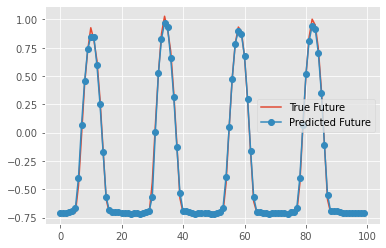

In [ ]:
bestmodel=tf.keras.models.load_model('best_model.h5')
x=100
plt.plot(range(x),te_labels[0:x],label='True Future')
plt.plot(bestmodel.predict(test[:x]),marker='o',label='Predicted Future')
plt.legend()
plt.ylabel('Normalised Clear Sky Irradiance')
plt.xlabel('Hours After First Recording')

lstm_mse=tf.keras.losses.MSE(te_labels.reshape(-1),bestmodel.predict(test).reshape(-1))
print(lstm_mse)

Seems 27 Is the best history size. This is just over a days worth of data which makes sense due to the periodicity of solar radiance.